In [127]:
import numpy as np
import astropy.units as u
from astropy.constants import G, c, m_p, k_B, M_sun
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Hyper-Eddington accretion flows on to massive BHs
Kohei Inayoshi, Zoltán Haiman, Jeremiah P. Ostriker

[arXiv:1511.02116, Jul. 2016](https://arxiv.org/abs/1511.02116)

### The Analytic Argument

Following Inayoshi et al. (2016) section 3.4, we can code up the analytic argument they proposed based on their hydrodynamical simulations. I will attempt to reproduce Figure 7 (below) of the paper using the analytical equations rather than the simulation results.

![figure 7](./inayoshi_fig7.png)

As they state in the paper, the relation between the H II region/radius and the Bondi radius determines the transition to the steady hyper-Eddington phase. The Bondi radius can be derived by the Bondi accretion rate for isothermal gas. Bondi accretion describes spherically symmetric accretion onto a compact object ([Bondi 1952](https://ui.adsabs.harvard.edu/abs/1952MNRAS.112..195B/abstract)).

$$ \dot{M}_B = \pi e^{3/2} \rho_\infty R^2_B c_\infty = \pi e^{3/2} \rho_\infty \frac{G^2 M^2_\text{BH}}{c^3_\infty}$$

Here $c_\infty = \sqrt{k_B T_\infty/(\mu m_p)}$ where $\mu=1.22$ and $T_\infty=10^4 \text{K}$ which yields the following approximate Bondi radius:

$$R_B \simeq 1.96 \times 10^{18} \frac{M_\text{BH}}{10^4 M_\odot} \frac{10^4 \text{K}}{T_\infty} \ \text{cm} $$

For steady hyper-Eddington accretion, the H II region should lie within the Bondi radius ($R_\text{H II} < R_B$) to avoid radiation heating and pressure affecting the gas dynamics at the Bondi radius and thus suppressing accretion.

In the hydrodynamical simulations, Inayoshi et al. found that for the case of higher BH masses, the H II region is always confined within the Bondi radius and shrinks dramatically at $t\gtrsim2.4\times 10^{5} \text{yr}$

The analytical equation for the H II region radius is estimated as:

$$R_\text{H II}=\left[ \frac{3 Q_\text{ion}}{4\pi \alpha_{\text{rec, B}}n^2_\infty}\right]^{1/3}.$$

Here $Q_\text{ion} (\propto L)$ is the ionizing photon number flux and $\alpha_{\text{rec, B}}$ is the H radiative recombination coefficient. In the trapping model explored in the paper, we are dealing with Eddington-limited luminosity setting the maximum value of $Q_\text{ion}$ to $L_\text{Edd}/(h\langle\nu\rangle)\propto M_\text{BH}$:

$$R_\text{H II}=1.8 \times 10^{18} \left( \frac{M_\text{BH}}{10^4 M_\odot}\right)^{1/3} \left( \frac{n_\infty}{10^{5} \text{cm}^{-3}}\right)^{-2/3} \left( \frac{T_\text{H II}}{10^{4} \text{K}}\right)^{0.28} \ \text{cm}.$$

To be conservative they take $R_\text{H II} \approx R_\text{HII, max}/2$, leading to the following condition for transition to hyper-Eddington accretion:

$$ \left( \frac{M_\text{BH}}{10^4 M_\odot}\right)  \left( \frac{n_\infty}{10^{5} \text{cm}^{-3}}\right) \gtrsim 0.64 \left( \frac{T_\infty}{10^4 \text{K}}\right)^{3/2} \left( \frac{T_\text{H II}}{10^4 \text{K}}\right)^{0.42}$$

or 

$$\dot{m} = \frac{\dot{M}_B}{\dot{M}_\text{Edd}} \gtrsim 4.6 \times 10^{3} \left( \frac{T_\text{H II}}{10^4 \text{K}} \right)^{0.42}.$$

Given their results with the hydrodynamical simulations and steady vs episodic hyper-Eddington accretion bursts, they set the hyper-Eddington accretion threshold as $\dot{m}=5000$.

Let's explore different BH masses and gas densities to illustrate the parameters space that allows for hyper-Eddington accretion.

In [128]:
# electron scattering opacity
# 0.20(1+X) cm^2 g^-1
kappa_es = (0.34 * u.cm**2 / u.g)

# mass accretion rate
def accretion_rate(M_BH, n_inf, T=10**4 * u.K, mu=1.22):
    
    # gas density
    rho_inf = n_inf * mu * m_p.cgs

    # gas sound speed
    c_inf = np.sqrt((k_B.to((u.cm**2 * u.g) / (u.s**2 * u.K)) * T)/(mu * m_p.cgs))

    # bondi accretion rate
    bondi_accretion = np.pi * np.exp(1.5) * rho_inf * ((G.cgs**2 * M_BH**2)/(c_inf**3))

    # eddington accretion rate
    eddington_accretion = (4 * np.pi * c.cgs * G.cgs * M_BH )/(kappa_es * c.cgs**2)

    return (bondi_accretion/eddington_accretion).cgs

They calculate the boundary between the accretion modes and find it to be:
$$\left( \frac{M_\text{BH}}{10^4 M_\odot} \right) \left( \frac{n_\infty}{10^5 \text{cm}^{-3}} \right) = 1/\sqrt{2} \simeq 0.71$$

In [129]:
# compute critical accretion rate

accretion_rate(10**4*M_sun, (10**5 *u.cm**-3)/np.sqrt(2))

<Quantity 3929.58875848>

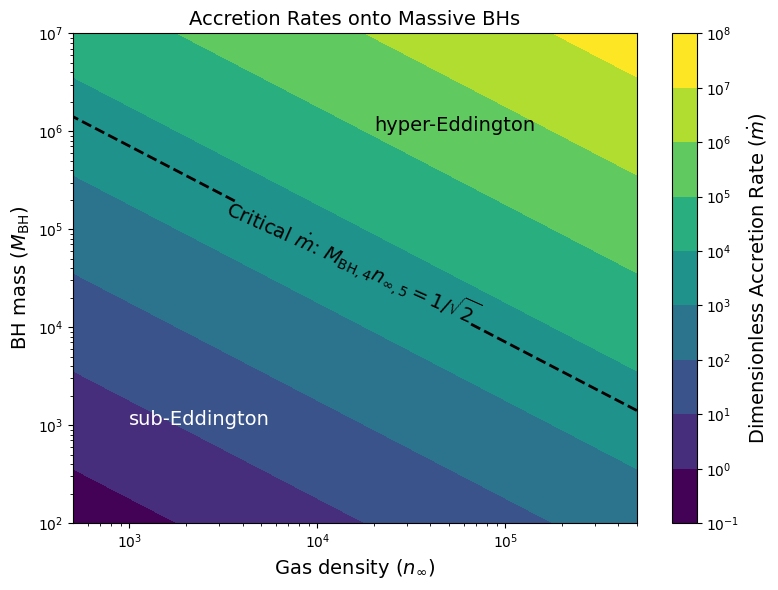

In [130]:
# explore M_BH and n parameter space
M_BH_vals = np.logspace(2, 7, 100) * M_sun
n_vals = np.logspace(2.7, 5.7, 100) 

M_BH, n = np.meshgrid(M_BH_vals, n_vals)
accretion_rates = accretion_rate(M_BH, n * u.cm**-3)

norm = LogNorm(vmin=accretion_rates.min(), vmax=accretion_rates.max())

#plotting stuff
plt.figure(figsize=(8, 6))
contour = plt.contourf(n, M_BH.to(u.M_sun).value, accretion_rates, levels=20, cmap='viridis', norm=norm)
plt.yscale('log')
plt.xscale('log')


critical_contour = plt.contour(n, M_BH.to(u.M_sun).value, accretion_rates, levels=[3929.5888], colors='black', linestyles='--', linewidths=2)
plt.clabel(critical_contour, fmt={3929.5888: r'Critical $\dot{m}$: $M_{\rm BH,4} n_{\infty,5} = 1/\sqrt{2}$'}, inline=True, fontsize=14)

cbar = plt.colorbar(contour)
cbar.set_label("Dimensionless Accretion Rate ($\dot{m}$)", fontsize=14)


plt.xlabel("Gas density ($n_{\infty}$)", fontsize=14)
plt.ylabel("BH mass ($M_{\\rm BH}$)", fontsize=14)
plt.title("Accretion Rates onto Massive BHs", fontsize=14)


plt.text(1e3,  1e3, 'sub-Eddington', color='white', fontsize=14)
plt.text(2e4,  1e6, 'hyper-Eddington', color='black', fontsize=14)

plt.tight_layout()
plt.show()